In [45]:
## Import Libraries
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import streamlit as st

In [46]:
url = r"C:\Users\Data Professor\Desktop\Hypertension Project\hypertension_dataset.csv"  ## csv_file

In [47]:
df = pd.read_csv(url)

In [48]:
df.head()  ## frist 5 rows of dataset

,Age,Salt_Intake,Stress_Score,BP_History,Sleep_Duration,BMI,Medication,Family_History,Exercise_Level,Smoking_Status,Has_Hypertension
0,69,8.0,9,Normal,6.4,25.8,NaN,Yes,Low,Non-Smoker,Yes
1,32,11.7,10,Normal,5.4,23.4,NaN,No,Low,Non-Smoker,No
2,78,9.5,3,Normal,7.1,18.7,NaN,No,Moderate,Non-Smoker,No
3,38,10.0,10,Hypertension,4.2,22.1,ACE Inhibitor,No,Low,Non-Smoker,Yes
4,41,9.8,1,Prehypertension,5.8,16.2,Other,No,Moderate,Non-Smoker,No


In [49]:
df.shape  ## rows and coluns of the dataset

(1985, 11)

In [50]:
df.columns = df.columns.str.lower()  ## converting columns to lower case 
df.columns = df.columns.str.strip()  ## removing extra spaces in columns
    

In [51]:
df.info()  ## checking the information and structure of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1985 non-null   int64  
 1   salt_intake       1985 non-null   float64
 2   stress_score      1985 non-null   int64  
 3   bp_history        1985 non-null   object 
 4   sleep_duration    1985 non-null   float64
 5   bmi               1985 non-null   float64
 6   medication        1186 non-null   object 
 7   family_history    1985 non-null   object 
 8   exercise_level    1985 non-null   object 
 9   smoking_status    1985 non-null   object 
 10  has_hypertension  1985 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 170.7+ KB


In [52]:
df.duplicated().any()  ## checking for duplicated rows 

np.False_

In [53]:
df.isna().any()  #3 checking for misiing values 

age                 False
salt_intake         False
stress_score        False
bp_history          False
sleep_duration      False
bmi                 False
medication           True
family_history      False
exercise_level      False
smoking_status      False
has_hypertension    False
dtype: bool

In [54]:
df.isna().sum()  ## identifying missing values 

age                   0
salt_intake           0
stress_score          0
bp_history            0
sleep_duration        0
bmi                   0
medication          799
family_history        0
exercise_level        0
smoking_status        0
has_hypertension      0
dtype: int64

In [55]:
df["medication"].value_counts()  ## medication count

medication
Beta Blocker     412
ACE Inhibitor    323
Diuretic         245
Other            206
Name: count, dtype: int64

In [56]:
df["medication"] = df["medication"].fillna("None")  ## handling missing values in medication column

In [57]:
df["medication"].isna().any()  ## confirming no null

np.False_

In [58]:
df["has_hypertension"] = df["has_hypertension"].replace({"Yes":1, "No":0})  ## converting target to binary

C:\Users\Data Professor\AppData\Local\Temp\ipykernel_868\941030597.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["has_hypertension"] = df["has_hypertension"].replace({"Yes":1, "No":0})


In [59]:
df["has_hypertension"].value_counts()  ## target count to check for status balance

has_hypertension
1    1032
0     953
Name: count, dtype: int64

In [60]:
def train_data():
    df["medication"] = df["medication"].fillna("None")
    
    df["has_hypertension"] = df["has_hypertension"].replace({"Yes":1, "No":0})
    
    
    resampler = RandomUnderSampler()
    
    x = df.drop(["has_hypertension"], axis = 1)
    y = df["has_hypertension"]
    
    resampled_x, resampled_y = resampler.fit_resample(x,y)
    
    resampled_y.value_counts()
    
    
    x_train, x_test, y_train, y_test = train_test_split(resampled_x, resampled_y, test_size = .2, random_state = 42)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_data()



def create_processor():
    num_cols = x_train.select_dtypes(include=["number"]).columns 
    cat_cols = x_train.select_dtypes(include=["object"]).columns
    
    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")),
        ("scaler", StandardScaler())
    ])
    
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy = "most_frequent")),
        ("scaler", OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1))
    ])
    
    
    processor = ColumnTransformer(
        transformers=[
            ("num_pipe", num_pipe, num_cols),
            ("cat_pipe", cat_pipe, cat_cols)
        ], 
        remainder = "passthrough"
    )
    return processor

processor = create_processor()



def check_models():
    Models = {
        "Linear Model" : LogisticRegression(),
        "Tree Model" : DecisionTreeClassifier(),
        "Random Forest Model" : RandomForestClassifier(),
        "Vector Model" : SVC(),
        "Neighbors Model" : KNeighborsClassifier(),
        "XGBoost" : XGBClassifier()
    }
    
    for name, models in Models.items():
        model = Pipeline([
            ("transformer", processor),
            ("model", models)
        ]).fit(x_train, y_train)
        prediction = model.predict(x_test)
    
        report = classification_report(y_test, prediction)
        matrix = confusion_matrix(y_test, prediction)
        print(f"The Classification Report for {name}:")
        print(report)
        print()
        print(f"The Confusion Matrix for {name}:")
        print(matrix)
        print("-"*100)


check_models()
    
    

The Classification Report for Linear Model:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       188
           1       0.82      0.80      0.81       194

    accuracy                           0.81       382
   macro avg       0.81      0.81      0.81       382
weighted avg       0.81      0.81      0.81       382


The Confusion Matrix for Linear Model:
[[155  33]
 [ 39 155]]
----------------------------------------------------------------------------------------------------
The Classification Report for Tree Model:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       188
           1       0.96      0.94      0.95       194

    accuracy                           0.95       382
   macro avg       0.95      0.95      0.95       382
weighted avg       0.95      0.95      0.95       382


The Confusion Matrix for Tree Model:
[[181   7]
 [ 11 183]]
-----------------------------------

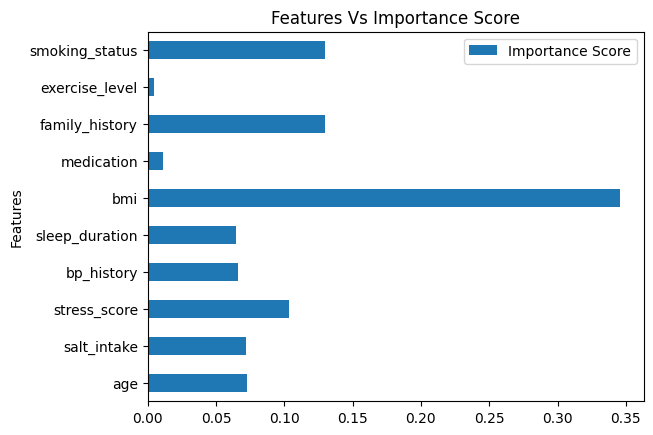

         Features  Importance Score
0             age          0.073008
1     salt_intake          0.071734
2    stress_score          0.103500
3      bp_history          0.066170
4  sleep_duration          0.064452
5             bmi          0.345766
6      medication          0.011524
7  family_history          0.129502
8  exercise_level          0.004610
9  smoking_status          0.129735


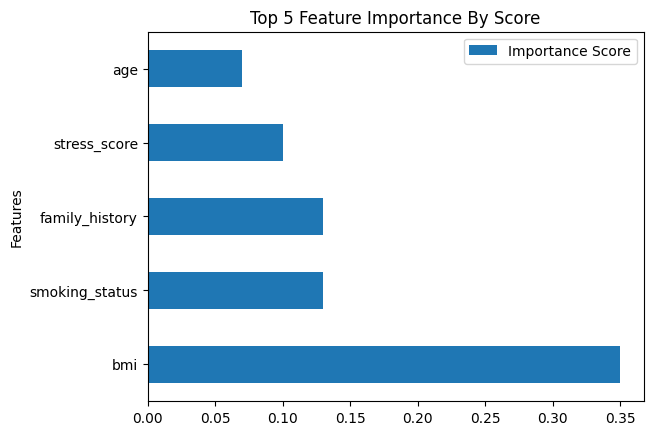

In [65]:
## xgboost model 
def train_xgboost():
    xgboost_model = Pipeline([
        ("transformer", processor),
        ("xgboost_model", XGBClassifier())
    ]).fit(x_train, y_train)
    
    
    ## feature importance 
    features = x_train.columns
    importance = xgboost_model.named_steps["xgboost_model"].feature_importances_
    
    importance_df = pd.DataFrame(
        {
            "Features" : features,
            "Importance Score" : importance
        }
    )
    importance_df
    importance_df.plot(x = "Features", y = "Importance Score", kind = "barh")
    plt.title("Features Vs Importance Score")
    plt.show()
    
    
    ## Top 5 Important Features
    importance_df.sort_values(by = "Importance Score", ascending = False).reset_index(drop = True).head().round(2)

    print(importance_df)
    
    ranked_importance = importance_df.sort_values(by = "Importance Score", ascending = False).reset_index().head().round(2).plot(x = "Features", y = "Importance Score", kind = "barh")
    plt.title("Top 5 Feature Importance By Score")
    plt.show()


train_xgboost()

In [ ]:
## joblib.dump(xgboost_model, "hypertension_xgboost_model.pkl")